### Winograd NLI Task:

### For WNLI, Sentence B replaces sentences A's ambiguous pronoun with one of the nouns. Now the task is to tell whether the replaced noun is correct or not



###  Importing the required libraries

In [1]:
import pickle
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

### Checking if gpu is availabe

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A4000


### Loading the dataset

In [3]:
dataset = load_dataset('glue', 'wnli')
dataset

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/wnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 635
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 71
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 146
    })
})

### Removing first word

In [4]:
train_s1 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['train']['sentence1']]
train_s2 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['train']['sentence2']]
test_s1 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test']['sentence1']]
test_s2 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test']['sentence2']]

### Removing last word

In [30]:
train_s1 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['train']['sentence1']]
train_s2 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['train']['sentence2']]
test_s1 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test']['sentence1']]
test_s2 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test']['sentence2']]

### Removing nouns and verbs

In [4]:
import nltk
from nltk import pos_tag

def remove_nouns(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'NN' and pos != 'NNP' and pos != 'NNS']
    return ' '.join(filtered_sentence)

def remove_verbs(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
    return ' '.join(filtered_sentence)

In [5]:
no_nouns_train_s1 = []
no_verbs_train_s1 = []

for sentence in dataset['train']['sentence1']:
    no_nouns_train_s1.append(remove_nouns(sentence))
    no_verbs_train_s1.append(remove_verbs(sentence))

no_nouns_train_s2 = []
no_verbs_train_s2 = []

for sentence in dataset['train']['sentence2']:
    no_nouns_train_s2.append(remove_nouns(sentence))
    no_verbs_train_s2.append(remove_verbs(sentence))

In [6]:
no_nouns_test_s1 = []
no_verbs_test_s1 = []

for sentence in dataset['test']['sentence1']:
    no_nouns_test_s1.append(remove_nouns(sentence))
    no_verbs_test_s1.append(remove_verbs(sentence))

no_nouns_test_s2 = []
no_verbs_test_s2 = []

for sentence in dataset['test']['sentence2']:
    no_nouns_test_s2.append(remove_nouns(sentence))
    no_verbs_test_s2.append(remove_verbs(sentence))

### Swap Text

In [4]:
import nltk
import random
from nltk.tokenize import word_tokenize

def random_swap_words(sentence):
    words = word_tokenize(sentence)
    if len(words) >= 2:
        i, j = random.sample(range(len(words)), 2)
        words[i], words[j] = words[j], words[i]
        return " ".join(words)
    else:
        return sentence

train_s1 = [random_swap_words(sentence) for sentence in dataset['train']['sentence1']]
test_s1 = [random_swap_words(sentence) for sentence in dataset['test']['sentence1']]

train_s2 = [random_swap_words(sentence) for sentence in dataset['train']['sentence2']]
test_s2 = [random_swap_words(sentence) for sentence in dataset['test']['sentence2']]

print("Original Sentences:")
print(dataset['train']['sentence1'][:5])
print("\nRandomly Swapped Sentences:")
print(train_s1[:5])


Original Sentences:
['I stuck a pin through a carrot. When I pulled the pin out, it had a hole.', "John couldn't see the stage with Billy in front of him because he is so short.", 'The police arrested all of the gang members. They were trying to stop the drug trade in the neighborhood.', "Steve follows Fred's example in everything. He influences him hugely.", 'When Tatyana reached the cabin, her mother was sleeping. She was careful not to disturb her, undressing and climbing back into her berth.']

Randomly Swapped Sentences:
['I stuck a pin through a carrot . When I pulled the pin had , it out a hole .', "John could n't see the stage with short in front of him because he is so Billy .", 'The police arrested all of stop gang members . They were trying to the the drug trade in the neighborhood .', "Steve follows Fred influences example in everything . He 's him hugely .", 'When Tatyana reached the cabin , her mother was sleeping . She was careful not berth disturb her , undressing and c

### Add Text

In [4]:
import random
from faker import Faker
from typing import List

def add_random_words(sentences: List[str]):
    fake = Faker()
    new_sentences = []
    for sentence in sentences:
        words = sentence.split()
        num_words_to_add = int(len(words) / 5)
        for i in range(num_words_to_add):
            insert_index = random.randint(0, len(words) - 1)
            words.insert(insert_index, fake.word())
        new_sentences.append(" ".join(words))
    return new_sentences


train_s1 = add_random_words(dataset['train']['sentence1'])
test_s1 = add_random_words(dataset['test']['sentence1'])

train_s2 = add_random_words(dataset['train']['sentence2'])
test_s2 = add_random_words(dataset['test']['sentence2'])

print("Original Sentences:")
print(dataset['train']['sentence1'][:5])
print("\nRandomly Swapped Sentences:")
print(train_s1[:5])


Original Sentences:
['I stuck a pin through a carrot. When I pulled the pin out, it had a hole.', "John couldn't see the stage with Billy in front of him because he is so short.", 'The police arrested all of the gang members. They were trying to stop the drug trade in the neighborhood.', "Steve follows Fred's example in everything. He influences him hugely.", 'When Tatyana reached the cabin, her mother was sleeping. She was careful not to disturb her, undressing and climbing back into her berth.']

Randomly Swapped Sentences:
['I out stuck a pin through a carrot. When I pulled real down the pin out, it had a hole.', "John couldn't see the stage with Billy everybody in front special of him because improve he is so short.", 'The police arrested all of the hundred gang members. They were trying to stop coach the drug trade customer in the neighborhood.', "Steve together follows Fred's example set in everything. He influences him hugely.", 'When and Tatyana reached the cabin, her mother ve

### Change Char

In [4]:
import random
import string

def replace_characters(sentence, probability=0.10):
    new_sentence = ""
    for char in sentence:
        if random.random() < probability:
            char = random.choice(string.ascii_letters)
        new_sentence += char
    return new_sentence

train_s1 = [replace_characters(sentence) for sentence in dataset['train']['sentence1']]
test_s1 = [replace_characters(sentence) for sentence in dataset['test']['sentence1']]

train_s2 = [replace_characters(sentence) for sentence in dataset['train']['sentence2']]
test_s2 = [replace_characters(sentence) for sentence in dataset['test']['sentence2']]

print("Original Sentences:")
print(dataset['train']['sentence1'][:5])
print("\nRandomly Swapped Sentences:")
print(train_s1[:5])


Original Sentences:
['I stuck a pin through a carrot. When I pulled the pin out, it had a hole.', "John couldn't see the stage with Billy in front of him because he is so short.", 'The police arrested all of the gang members. They were trying to stop the drug trade in the neighborhood.', "Steve follows Fred's example in everything. He influences him hugely.", 'When Tatyana reached the cabin, her mother was sleeping. She was careful not to disturb her, undressing and climbing back into her berth.']

Randomly Swapped Sentences:
['I ytuck a piu through a carryt. When I pulled the Qrn ouD, it had aVhKle.', "JZhn coulhn't see jhN stage with Billy Xn frBnt of him bbcause he is so shorR.", 'The pWlice arrested kll of the gabg members.QThIy wwre trying Qo stop the drug trxde in the neighborhood.', "SteveyAollows Fced's examplzSin evTrything. He influences him hugely.", 'When Tatyana rewchedzthe cabin, hKr mothiF wasosleeping. vhe was careful notDto disturb her, undressing and climbingLback int

### Bias

In [5]:

def changeGender(str):
    dictionary = {
    "batman": "batwoman", "batwoman": "batman",
    "boy": "girl", "girl": "boy",
    "boyfriend": "girlfriend", "girlfriend": "boyfriend",
    "father": "mother", "mother": "father",
    "husband": "wife", "wife": "husband",
    "he": "she", "she": "he", "He":"She", "She":"He",
    "his": "her", "her": "his", "His":"Her", "Her":"His",
    "male": "female", "female": "male",
    "man": "woman", "woman": "man",
    "Mr": "Ms", "Mr": "Ms",
    "sir": "madam", "madam": "sir",
    "son": "daughter", "daughter": "son",
    "uncle": "aunt", "aunt": "uncle",
    }

    str = str + ' ' # Append a space at the en
    temp = ""
    ans = ""

    for i in range(len(str)):
        if str[i] != ' ':
            temp += str[i]
        else:
            if temp in dictionary:
                temp = dictionary[temp]

            ans = ans + temp + ' '
            temp = ""

    return ans

train_s1 = [changeGender(sentence) for sentence in dataset['train']['sentence1']]
test_s1 = [changeGender(sentence) for sentence in dataset['test']['sentence1']]

train_s2 = [changeGender(sentence) for sentence in dataset['train']['sentence2']]
test_s2 = [changeGender(sentence) for sentence in dataset['test']['sentence2']]

print("Original Sentences:")
print(dataset['train']['sentence1'][:5])
print("\nRandomly Swapped Sentences:")
print(train_s1[:5])


Original Sentences:
['I stuck a pin through a carrot. When I pulled the pin out, it had a hole.', "John couldn't see the stage with Billy in front of him because he is so short.", 'The police arrested all of the gang members. They were trying to stop the drug trade in the neighborhood.', "Steve follows Fred's example in everything. He influences him hugely.", 'When Tatyana reached the cabin, her mother was sleeping. She was careful not to disturb her, undressing and climbing back into her berth.']

Randomly Swapped Sentences:
['I stuck a pin through a carrot. When I pulled the pin out, it had a hole. ', "John couldn't see the stage with Billy in front of him because she is so short. ", 'The police arrested all of the gang members. They were trying to stop the drug trade in the neighborhood. ', "Steve follows Fred's example in everything. She influences him hugely. ", 'When Tatyana reached the cabin, his father was sleeping. He was careful not to disturb her, undressing and climbing bac

### Using the tokenizer from huggingface

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gchhablani/bert-base-cased-finetuned-wnli")

### Loading the pre-trained and fine-tuned models from huggingface and moving them to device

In [8]:
preTrainedModel = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels = 2,
                                                      output_attentions = True,
                                                      output_hidden_states = True,)
preTrainedModel.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
fineTunedModel = AutoModelForSequenceClassification.from_pretrained("gchhablani/bert-base-cased-finetuned-wnli")
fineTunedModel.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Forming dataloaders

In [15]:
tokenised_dataset = tokenizer(train_s1, train_s2,padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['train']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
train_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [9]:
tokenised_dataset = tokenizer(test_s1, test_s2, padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['test']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
test_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### Getting CLS hidden states for all layers [13, number of sampes, 768] to check layer-wise accuracy

In [17]:
def getCLSHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:

        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=b_token_type_ids,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i][:,0,:].to("cpu")
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i][:,0,:].to("cpu")
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [18]:
hiddenStates = getCLSHiddenStates(preTrainedModel, train_dataloader)
preTrainedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
preTrainedCLSHiddenStatesTrain.shape

torch.Size([635, 768])

In [19]:
hiddenStates = getCLSHiddenStates(preTrainedModel, test_dataloader)
preTrainedCLSHiddenStatesTest = torch.stack(hiddenStates, dim = 0)
preTrainedCLSHiddenStatesTest.shape

torch.Size([146, 768])

In [20]:
hiddenStates = getCLSHiddenStates(fineTunedModel, train_dataloader)
fineTunedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
fineTunedCLSHiddenStatesTrain.shape

torch.Size([635, 768])

In [21]:
hiddenStates = getCLSHiddenStates(fineTunedModel, test_dataloader)
fineTunedCLSHiddenStatesTest = torch.stack(hiddenStates, dim = 0)
fineTunedCLSHiddenStatesTest.shape

torch.Size([146, 768])

In [10]:
def getLabels(model, data_loader):
    predictions = []
    for batch in data_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            results = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, return_dict=True)
            logits = results.logits
            pred = torch.argmax(logits, dim = 1)
            predictions.extend(pred.tolist())
    return predictions

In [11]:
import numpy as np
import pandas as pd
predictions = getLabels(fineTunedModel, test_dataloader)
filename = 'WNLI.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Forming logistic regressions at each layer to find the layer-wise accuracy for pre-trained and fine-tuned model

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

sc_x = StandardScaler()
for i in range(13):
    xtrain = sc_x.fit_transform(preTrainedCLSHiddenStatesTrain[i])
    xtest = sc_x.fit_transform(preTrainedCLSHiddenStatesTest[i])
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label']) 
    
    preTrain_pred=logreg.predict(xtest)
    filename = 'p{0}/WNLI.tsv'.format(i)
    result = pd.DataFrame(preTrain_pred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)
    
    
    xtrain = sc_x.fit_transform(fineTunedCLSHiddenStatesTrain[i]) 
    xtest = sc_x.fit_transform(fineTunedCLSHiddenStatesTest[i])
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label'])
    
    fineTuned_pred=logreg.predict(xtest)
    filename = 'f{0}/WNLI.tsv'.format(i)
    result = pd.DataFrame(fineTuned_pred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)

### Finding the accuracy of the final layer using the classifier of the fine-tuned model

In [18]:
params = list(fineTunedModel.named_parameters())
dense = torch.nn.Linear(768, 768,device=device, bias = True)
activation = torch.nn.Tanh()
dropout = torch.nn.Dropout(p=0.1)
classifier = torch.nn.Linear(in_features=768, out_features=2,  bias = True)
with torch.no_grad():
    dense.weight = params[-4][1]
    dense.bias = params[-3][1]
    classifier.weight = params[-2][1]
    classifier.bias = params[-1][1]

pooled_output = activation(dense(fineTunedCLSHiddenStatesTest[-1,:,:].to('cuda:0')))
dropout_op = dropout(pooled_output)
logits = classifier(dropout_op)
predictions = torch.argmax(logits, dim = 1)

In [19]:
import pandas as pd
predictions = predictions.to('cpu')
filename = 'biasWNLI.tsv'.format(i)
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Obtaining hidden states to find the CKA metric between the pre-trained and fine-tuned model on test dataset

In [20]:
def getHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=b_token_type_ids,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i].to("cpu").mean(dim = 1)
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [21]:
hiddenStates = getHiddenStates(preTrainedModel, test_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_wnli.pt')
preTrainedHiddenStates.shape

torch.Size([13, 146, 768])

In [22]:
hiddenStates = getHiddenStates(fineTunedModel, test_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_wnli.pt')
fineTunedHiddenStates.shape

torch.Size([13, 146, 768])

In [23]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [24]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 14)
plt.yticks(np.arange(0,13), fontsize = 14)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(str(cka_matrix[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained BERT', fontsize = 17)
plt.xlabel('Fine-tuned BERT', fontsize = 17)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('WNLI_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('WNLI_preTrained_fineTuned.jpg',  bbox_inches='tight')

## STIR

In [3]:
preTrainedHiddenStates = torch.load('preTrainedHiddenStates_wnli.pt').to(device)
fineTunedHiddenStates  = torch.load('fineTunedHiddenStates_wnli.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 146, 768]) torch.Size([13, 146, 768])


In [4]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [5]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [6]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [9]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [10]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [11]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

In [12]:
STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

In [13]:
STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

In [14]:
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

STIRm2m1: [0.9940255  0.99501747 0.9951727  0.9959672  0.9954236  0.99623317
 0.9955594  0.9953436  0.99590296 0.9966103  0.99696153 0.9960885
 0.99562466]
STIRm1m2: [0.99402726 0.9950166  0.99519014 0.99603254 0.99550104 0.9961244
 0.99540883 0.9952222  0.9956045  0.9956476  0.99591506 0.9952017
 0.9954695 ]
CKA: [1.         0.99999    0.99980986 0.9994545  0.998627   0.9979518
 0.99767727 0.9966651  0.995922   0.9950506  0.99276084 0.9893781
 0.96255416]


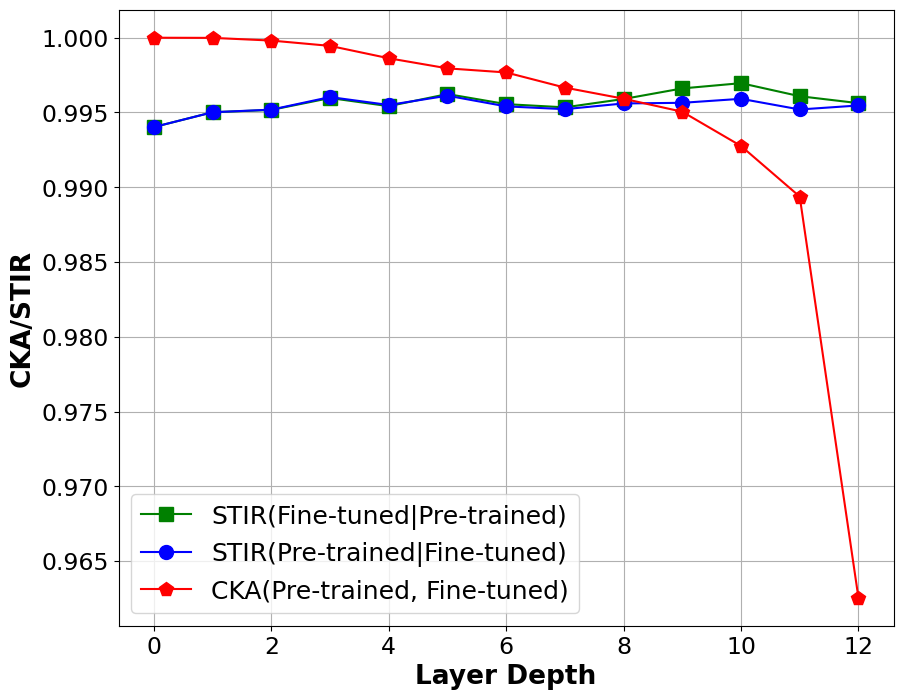

In [2]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=18)
plt.xlabel('Layer Depth', fontsize = 19, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 19, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.tight_layout()
#plt.show()
plt.savefig('WNLI STIR.pdf', bbox_inches='tight')
plt.savefig('WNLI STIR.jpg', bbox_inches='tight')